First check that you have pytorch installed, instructions are here: https://pytorch.org/get-started/locally/ , prefferably do it with anaconda if you can, I think that will lead to less problems down the road if we use other libraries.

If cuda toolkit isnt available and you have an nvidia gpu try to get that too (it might be contained within anaconda pytorch package): https://docs.nvidia.com/cuda/cuda-installation-guide-microsoft-windows/index.html

Also note that because the dataset is large I added it to the .gitignore, you should download it from here : https://www.kaggle.com/c/cassava-leaf-disease-classification/data, and extract it into the data/ folder of the project


In [1]:
import sys
print(sys.version)

3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]


In [2]:
import torch
import os 
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import torchvision
import pandas as pd
import skorch
import pickle

from torch import FloatTensor, LongTensor, nn, optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torchvision import transforms, datasets, models
from IPython.core.debugger import set_trace
%matplotlib inline

use_cuda = True
if not torch.cuda.is_available() or not use_cuda:
    print("if you have an nvidia gpu get the cuda core package")
    device = torch.device('cpu')
else:
    print("cuda is available")
    # torch.cuda.set_device(0) # possible fix to illegal memory access error
    device = torch.device('cuda:0')

cuda is available


Splitting data into train and test sets and loading the validation set

In [3]:
#setting the path to the directory containing the pics
path = './data/train_images'
test_path = './data/test_images'

labelled_dataset = pd.read_csv(r'./data/train.csv')
submission = pd.read_csv(r'./data/sample_submission.csv')

with open('./data/label_num_to_disease_map.json') as f:
    mapping_dict = json.load(f)
print(mapping_dict)

#labelled_dataset = labelled_dataset.head(250) # tiny dataset for fast debugging, comment when training for real

# Parameters
train, test = train_test_split(labelled_dataset, test_size=0.25, random_state=7, stratify=labelled_dataset.label)

should_match_index = 6
print(labelled_dataset.values[should_match_index])

{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}
['1000910826.jpg' 2]


In [4]:
from collections import Counter

Counter(labelled_dataset.label) # counts the elements' frequency

Counter({0: 1087, 3: 13158, 1: 2189, 2: 2386, 4: 2577})

In [5]:
print("Majority classifier accuracy: {}".format(13158/(1087+13158+2189+2386+2577)))

Majority classifier accuracy: 0.6149460204701593


Majority classifier (so our baseline) has an accuracy of 61.49%


Label Cassava Bacterial Blight (CBB) appears 1087 times<br>
Label Cassava Brown Streak Disease (CBSD) appears 2189 times<br>
Label Cassava Green Mottle (CGM) appears 2386 times<br>
Label Cassava Mosaic Disease (CMD) appears 13158 times<br>
Label Healthy appears 2577 times<br>
Because the labels arent equally represented the dataset split is stratified so each split has an equal amount of a certain label
<br><br>
Create custom dataset class for the images, and a transform to be applied to these images as part of preprocessing for learning <br>
All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].


In [6]:
class CassavaDataset(Dataset):
    def __init__(self, data, path , transform = None):
        super().__init__()
        self.data = data.values
        self.path = path
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        img_name,label = self.data[index]
        img_path = os.path.join(self.path, img_name)
        image = img.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

# original resolution is 800 x 600
# Parameters
cassava_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((600,600)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(340), # minimum is 299 for inceptionv3 224. Bigger image = more vram usage
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    # (the means and standard deviations of each of the 3 image channels)
])

cassava_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((600,600)),
    #transforms.CenterCrop(340), #minimum is 299 for inceptionv3 224 for everything else
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    # (the means and standard deviations of each of the 3 image channels)
])

train_dataset = CassavaDataset(train, path, cassava_transform )
test_dataset = CassavaDataset(test, path, cassava_test_transform)
valid_dataset = CassavaDataset(submission, test_path, cassava_test_transform)

print(len(train_dataset))
print(len(test_dataset))
print(len(valid_dataset))
print(len(labelled_dataset))

16047
5350
1
21397


In [7]:
train_dataset[0] # how a transformed image tensor looks like, its label is 2

(tensor([[[ 1.7694,  1.7865,  1.8037,  ...,  0.6049,  0.2282, -0.3712],
          [ 1.5639,  1.5125,  1.4783,  ..., -0.2856, -0.8507, -1.0219],
          [ 1.5639,  1.5639,  1.5297,  ..., -0.5767, -0.9877, -0.8678],
          ...,
          [ 0.2453,  0.2111,  0.2796,  ...,  0.0056, -0.0629, -0.1486],
          [ 0.2453,  0.2967,  0.3309,  ..., -0.0458, -0.1486, -0.2171],
          [ 0.1939,  0.2967,  0.4166,  ...,  0.0056,  0.0056, -0.0629]],
 
         [[ 0.3978,  0.3803,  0.3978,  ..., -0.0049, -0.1800, -0.5126],
          [ 0.9755,  0.9055,  0.8354,  ..., -1.2829, -1.5105, -1.3179],
          [ 1.7808,  1.7283,  1.6408,  ..., -1.2304, -1.3704, -0.9853],
          ...,
          [ 0.4503,  0.4153,  0.5028,  ...,  0.0826,  0.1352,  0.1702],
          [ 0.4328,  0.4853,  0.5203,  ..., -0.0399, -0.0399, -0.0049],
          [ 0.3452,  0.4328,  0.5553,  ..., -0.1099, -0.0049, -0.0049]],
 
         [[ 0.7228,  0.6705,  0.6008,  ...,  1.4025,  0.7751, -0.3055],
          [ 0.8448,  0.7054,

In [8]:
# Parameters
n_epochs = 70 # on final training this should be high (around 30 for my desktop pc)
num_classes = 5 # 5 labels
batch_size = 32 # minimum batch size for inception v3 is 2, 20 to 32 seems to be fine for me (no cuda vram errors)
steps_per_epoch = len(train_dataset)/batch_size
params_dict_main = {
    "vgg": {
        "lr": 404,
        "wd": 404,
    },
    "google_net": {
        "lr": 404,
        "wd": 404,
    },
    "resnet": {
        "lr": 404,
        "wd": 404,
    },
    "alexnet": {
        "lr": 404,
        "wd": 404,
    }
}
early_stopping_threshold = 4 # this many epochs of no improvement stops trainining

train_dataloader = DataLoader(dataset = train_dataset,batch_size = batch_size,shuffle=True,num_workers=0,pin_memory=True,drop_last=True)
valid_dataloader = DataLoader(dataset = valid_dataset,batch_size = batch_size,shuffle=False,num_workers=0,pin_memory=True,drop_last=True)
test_dataloader = DataLoader(dataset = test_dataset,batch_size = batch_size,shuffle=False,num_workers=0,pin_memory=True,drop_last=True)
# pin memory should be enabled if you use cuda cores to speed up transfer between cpu and gpu,
# drop last is there if the last batch contains 1 sample for inception v3 (if its not enabled for inception theres an error)
# num workers is 0 unless you're using linux or mac os x, because paralelization in windows is broken
# using Adam optimizer, the max batch size for me is around 28, after that it uses too much vram (i have 8gb)



# using SGD optimizer, i can use up to 32
# using different pre processing params, i could get bigger batch sizes since the images would be smaller

Show an image from the dataset

Index: 2
Filename: 1000910826.jpg


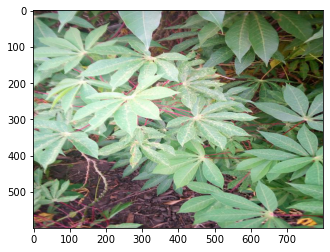

In [9]:
def show_image(index):  
    plt.imshow(img.imread('{}/{}'.format(path,labelled_dataset.values[index][0]))) # set the correct resolution here
    print('Index: {}'.format(labelled_dataset.values[index][1]))
    print('Filename: {}'.format(labelled_dataset.values[index][0]))
    
show_image(6)

Using resnet 18 pretrained pytorch model

In [10]:
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__) 
# Use this number below as the torchvision version for the alternative resnet model or else theres a version conflict

PyTorch Version:  1.7.1
Torchvision Version:  0.8.2


Model selection below, choices are "resnet", "alexnet", "vgg", "google_net"

In [11]:
def get_model(model_string):
    if model_string == "google_net":
        net = models.inception_v3(pretrained=True,aux_logits=False) # googlenet is based on inception v1, this is improved
        net = net.cuda() if use_cuda else net
        num_ftrs = net.fc.in_features
        net.fc = nn.Linear(num_ftrs, num_classes)

    if model_string == "vgg":
        net = models.vgg16(pretrained=True)
        net = net.cuda() if use_cuda else net
        net.fc = nn.Linear(4096, num_classes)

    if model_string == "alexnet":
        net = models.alexnet(pretrained=True)
        net = net.cuda() if use_cuda else net  
        net.fc = nn.Linear(4096, num_classes)

    if model_string == "resnet":
        #net = torch.hub.load('pytorch/vision:v0.2.2', 'resnet18', pretrained=True) 
        net = models.resnet18(pretrained=True)
        net = net.cuda() if use_cuda else net
        num_ftrs = net.fc.in_features
        net.fc = nn.Linear(num_ftrs, num_classes)
        
    net.fc = net.fc.cuda() if use_cuda else net.fc    
    return net
    
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

Do evaluation, (still have to try out parameters specified in paper, find out which are useful) <br>The original base code for the block above this text and 2 blocks below was found at the following link, but it was modified for our dataset and to work with our 4 different models not just resnet: https://www.pluralsight.com/guides/introduction-to-resnet <br> <br> What I did with the models is called feature extraction, the models were all pretrained on imagenet: <br>

In feature extraction, we start with a pretrained model and only update the final layer weights from which we derive predictions. It is called feature extraction because we use the pretrained CNN as a fixed feature-extractor, and only change the output layer.

In [12]:
# Will plot the accuracy of the models below and save them to a file
def plot_model_acc():
    fig = plt.figure(figsize=(20,10))
    plt.title("Train-Validation Accuracy for {}".format(model_name))
    plt.plot(train_acc, label='train')
    plt.plot(val_acc, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('accuracy', fontsize=12)
    plt.legend(loc='best')
    plt.savefig('./plots/{}_e{}_lr{}_bs{}.png'.format(model_name,n_epochs,str(learning_rate[model_name]).replace(".","dot"),batch_size), bbox_inches='tight')

In [13]:
from optimizers import DemonRanger
# this should be used after finding good starting parameters with the cross validation parameter tuning below
# Parameters
skip_this = True # find good starting parameters first, using cv, then set this to false
model_index = 0 # set model index to use here
string_array = ["vgg","google_net","resnet","alexnet"]

first_run = True
while(True and not skip_this):
    if(len(string_array) > 0):
        if not first_run:
            #Print and save graph
            plot_model_acc()

            del criterion # free up vram
            del optimizer
            del net
            torch.cuda.empty_cache()
            model_name = string_array.pop(0)
            net = get_model(model_name)
        else:
            model_name = string_array[model_index]
            net = get_model(model_name)
            string_array.remove(model_name)
            first_run = False

        # Parameters
        criterion = nn.CrossEntropyLoss() # used this since we have 5 mutually exclusive classes

        demon_adam = DemonRanger(params=net.parameters(),
                                lr=params_dict_main[model_name]["lr"],
                                weight_decay=params_dict_main[model_name]["wd"],
                                epochs = n_epochs,
                                step_per_epoch = steps_per_epoch, 
                                betas=(0.9,0.999,0.999), # restore default AdamW betas
                                nus=(1.0,1.0), # disables QHMomentum
                                k=0,  # disables lookahead
                                alpha=1.0, 
                                IA=False, # enables Iterate Averaging
                                rectify=False, # disables RAdam Recitification
                                AdaMod=False, #disables AdaMod
                                AdaMod_bias_correct=False, #disables AdaMod bias corretion (not used originally)
                                use_demon=True, #enables Decaying Momentum (DEMON)
                                use_gc=False, #disables gradient centralization
                                amsgrad=False # disables amsgrad
                                )
        optimizer = optim.SGD(net.parameters(), lr=learning_rate[model_name], momentum=0.9)

        improvement_patience = 0
    else:
        plot_model_acc()
        break
    print("-------------------------------------------------------------------")
    print("Using model: {}".format(model_name))
    print_every = int(len(train_dataloader)*0.1) # print upon completion of every 10% of the dataset
    if print_every == 0: print_every = 1
    valid_loss_min = np.Inf
    val_loss = []
    val_acc = []
    train_loss = []
    train_acc = []
    total_step = len(train_dataloader)
    for epoch in range(1, n_epochs+1):
        running_loss = 0.0
        correct = 0
        total=0
        print(f'Epoch {epoch}\n')
        for batch_idx, (data_, target_) in enumerate(train_dataloader):
            data_, target_ = data_.to(device), target_.to(device)
            optimizer.zero_grad()

            outputs = net(data_)
            #if model_name == "google_net": # for inception v3 (the google model we use): 
                # net(data_) returns logits and aux logits in a touple, we just use logits
                #outputs = outputs[0]
            loss = criterion(outputs, target_)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _,pred = torch.max(outputs, dim=1)

            #set_trace() # Debugger entrypoint for inspecting predictions

            correct += torch.sum(pred==target_).item()
            total += target_.size(0)
            if (batch_idx) % print_every == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
        train_acc.append(100 * correct / total)
        train_loss.append(running_loss/total_step)
        print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
        batch_loss = 0
        total_t=0
        correct_t=0
        with torch.no_grad():
            net.eval()
            for data_t, target_t in (test_dataloader):
                data_t, target_t = data_t.to(device), target_t.to(device)
                outputs_t = net(data_t)
                loss_t = criterion(outputs_t, target_t)
                batch_loss += loss_t.item()
                _,pred_t = torch.max(outputs_t, dim=1)
                correct_t += torch.sum(pred_t==target_t).item()
                total_t += target_t.size(0)
            val_acc.append(100 * correct_t/total_t)
            val_loss.append(batch_loss/len(test_dataloader))
            network_learned = batch_loss < valid_loss_min
            print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')


            if network_learned:
                valid_loss_min = batch_loss
                torch.save(net.state_dict(), './data/{}_best_model.pt'.format(model_name))
                improvement_patience = 0
                print('Improvement-Detected, save-model')
            else:
                improvement_patience += 1
        if improvement_patience > early_stopping_threshold: break
        net.train()


#print(target_,pred) # used for comparing correct class vs models predictions

Time can vary alot depending on your set parameters, cpu, gpu, whether you're using cuda etc. <br>

Now instead of rewriting the above boilerplate pytorch code for training and evaluating the model, ill do cross validation using the skorch library, which basically allows you to abstract away the unnecesarry code, do cross validation and hyper parameter tuning with grid search cv <br>

Cross validation is done on the training set only, so 75% of the total, this set is then split into k folds (in our case 3) then the model is trained on k-1 folds and evaluated on the remaining 1 fold, after the cross validation, i evaluate the models on the before unseen test set (25% of total)

In [14]:
from skorch import NeuralNetClassifier
from skorch.dataset import CVSplit
from skorch.helper import SliceDataset
from sklearn.metrics import accuracy_score, f1_score
from sklearn.experimental import enable_halving_search_cv # noqa this is a new recently added feature im trying out
from sklearn.model_selection import GridSearchCV,HalvingGridSearchCV

In [15]:
import gc
print("Skorch Version: ",skorch.__version__)
#del gs
#del net
gc.collect()
torch.cuda.empty_cache()

Skorch Version:  0.9.0


In [16]:
y_train = np.array(train.label)
y_test = np.array(test.label)

# because of vram, test this on your pc and try to use a range from 32 to 64
vgg_batch = 17
google_net_batch = 32
resnet_batch = 32
alexnet_batch = 32

params_dict = { # possible parameter combinations to evaluate 
    "vgg": {
        'lr': [0.0001,0.0005], # best so far 0.0005 83% 0.0003 82 % 0.00003  76 % (4)
        'optimizer__weight_decay': [0.0025,0.04], # best so far 0.0025, then  0.01 , then 0.0001
        'optimizer__momentum': [0.9], # for sgd only 
        'batch_size': [vgg_batch],
    },
    "google_net": {
        'lr': [0.001,0.01], # best so far 0.001 83.5%,  0.003 83 %, 2nd 0.03 78% (4)
        'optimizer__weight_decay': [0.01,0.001], # best so far 0.001, then 0.001
        'optimizer__momentum': [0.9], # for sgd only
        'batch_size': [google_net_batch],
    },
    "resnet": {
        'lr': [0.001,0.008],  # best so far 0.001 84%, 0.003 82%, 0.0003 78% (4)
        'optimizer__weight_decay': [0.01,0.001], # best so far 0.001 then 0 and 0.001
        'optimizer__momentum': [0.9], # for sgd only 
        'batch_size': [resnet_batch],
    },
    "alexnet": {
        'lr': [0.001,0.008],# best so far 0.001 76%,  0.0003 73% 0.00003  70 % (4)
        'optimizer__weight_decay': [0.01,0.001], # best 0.01, za 0.00003 vsi podobni (0,0.1,0.001)
        'optimizer__momentum': [0.9], # for sgd only
        'batch_size': [alexnet_batch],
    }
}
best_estimators = []

In [17]:
string_array = ["vgg","google_net","resnet","alexnet"] # also the order

skip_this = False # set this to true after finding good starting parameters here

best_params_models = []
# the code below basically compares the model tuned with the parameters above to find the best performing one, we then use
# the bigger native pytorch code chunk above to actually train a model with the best found params and evaluate it
first_run = True
while(True and not skip_this):
    if(len(string_array)>0):
        model_name = string_array.pop(0)
        net = get_model(model_name)
        gc.collect()
        torch.cuda.empty_cache()
        torch.backends.cudnn.benchmark = True # speeds up training by some variable amount
        first_run = False
    else:
        del gs
        gc.collect()
        torch.cuda.empty_cache()
        break
    print("---------------------")
    print("---------------------")
    print("Now cross validating {}------------------------------------------".format(model_name))
    print("---------------------")
    print("---------------------")
    skorch_classifier = NeuralNetClassifier(
        net,
        max_epochs=5,
        optimizer=torch.optim.SGD,
        criterion=nn.CrossEntropyLoss,
        device=device,
    )
    gs = HalvingGridSearchCV(skorch_classifier, # or GridSearchCV 
                      param_grid=params_dict[model_name], 
                      scoring='accuracy',
                      refit='accuracy', # competition entries will be evaluated bassed on classification accuracy
                      verbose=3, # outputs info
                      cv=3, # because the percentages of labels across folds are close to equal (stratified), and label 1
                     )      # only occurs 1000 times, 3 folds appears to be the maximum, with 333 cases of label 1 per fold
    train_sliceable = SliceDataset(train_dataset)
    gs.fit(train_sliceable, y_train)
    best_params_models.append(gs.best_params_)
    best_estimators.append(gs.best_estimator_) # saves the model
    with open('./cross_validation/models/{}_best_model_CV.pickle'.format(model_name), 'wb') as handle:
        pickle.dump(gs.best_estimator_, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('./cross_validation/best_params_{}.json'.format(model_name), 'w') as jsonfile: # Save best params for each model
        json.dump(gs.best_params_, jsonfile)
    
print(best_params_models) # order = ["vgg","google_net","resnet","alexnet"]
with open('./cross_validation/best_params.json', 'w') as jsonfile: # Save best params for each model
    json.dump(best_params_models, jsonfile)  

---------------------
---------------------
Now cross validating vgg------------------------------------------
---------------------
---------------------
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 5349
max_resources_: 16047
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 4
n_resources: 5349
Fitting 3 folds for each of 4 candidates, totalling 12 fits
  epoch    train_loss    valid_acc    valid_loss       dur
-------  ------------  -----------  ------------  --------
      1        1.6746       0.6821        0.8984  207.5842
      2        0.8812       0.7199        0.7951  164.4930
      3        0.7428       0.7507        0.7406  165.4968
      4        0.7032       0.7409        0.7185  159.6070
      5        0.6503       0.7493        0.7159  159.6180
[CV 1/3] END batch_size=17, lr=0.0001, optimizer__momentum=0.9, optimizer__weight_decay=0.0025; total time=15.2min
  epoch    train_loss    valid_acc    valid_loss       

  epoch    train_loss    valid_acc    valid_loss       dur
-------  ------------  -----------  ------------  --------
      1        1.0134       0.7626        0.6915  538.6530
      2        0.6546       0.7808        0.6084  542.5910
      3        0.5778       0.8033        0.5484  542.4066
      4        0.5665       0.8168        0.5353  546.9089
      5        0.5488       0.8037        0.5587  542.6827
[CV 1/3] END batch_size=17, lr=0.0005, optimizer__momentum=0.9, optimizer__weight_decay=0.04; total time=47.8min
  epoch    train_loss    valid_acc    valid_loss       dur
-------  ------------  -----------  ------------  --------
      1        1.0980       0.7397        0.7254  528.3366
      2        0.6861       0.7575        0.6704  541.9649
      3        0.5918       0.7612        0.7016  547.5273
      4        0.5625       0.7603        0.6539  563.4977
      5        0.5675       0.7766        0.6262  582.0993
[CV 2/3] END batch_size=17, lr=0.0005, optimizer__momentum=0.

      2        0.8765       0.7073        0.8012  98.3920
      3        0.7629       0.7367        0.7352  98.4950
      4        0.6629       0.7689        0.6549  98.4520
      5        0.5876       0.7801        0.6292  98.3000
[CV 3/3] END batch_size=32, lr=0.001, optimizer__momentum=0.9, optimizer__weight_decay=0.001; total time= 8.8min
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.9353       0.7073        0.8217  98.4180
      2        0.6817       0.7717        0.6465  98.3390
      3        0.6072       0.6975        0.7823  98.3800
      4        0.5682       0.7087        0.7603  98.5060
      5        0.5373       0.7213        0.7765  98.3920
[CV 1/3] END batch_size=32, lr=0.01, optimizer__momentum=0.9, optimizer__weight_decay=0.01; total time= 8.8min
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.9311 

      2        0.5849       0.8227        0.4972  443.2590
      3        0.5011       0.8424        0.4578  442.8790
      4        0.4583       0.8377        0.4478  443.5500
      5        0.4188       0.8417        0.4461  443.5990
---------------------
---------------------
Now cross validating resnet------------------------------------------
---------------------
---------------------
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 5349
max_resources_: 16047
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 4
n_resources: 5349
Fitting 3 folds for each of 4 candidates, totalling 12 fits
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.0037       0.6933        0.8015  71.0761
      2        0.7077       0.7605        0.6655  69.7130
      3        0.6136       0.7661        0.6171  69.9810
      4        0.5531       0.7787        0.6160  69.8

      5        0.4653       0.7479        0.6926  69.4840
[CV 3/3] END batch_size=32, lr=0.008, optimizer__momentum=0.9, optimizer__weight_decay=0.001; total time= 6.3min
----------
iter: 1
n_candidates: 2
n_resources: 16047
Fitting 3 folds for each of 2 candidates, totalling 6 fits
  epoch    train_loss    valid_acc    valid_loss       dur
-------  ------------  -----------  ------------  --------
      1        0.7951       0.7864        0.5895  209.1771
      2        0.5779       0.8173        0.5125  208.6800
      3        0.5174       0.8294        0.4777  208.9280
      4        0.4797       0.8393        0.4638  208.6000
      5        0.4565       0.8304        0.4628  209.0800
[CV 1/3] END batch_size=32, lr=0.001, optimizer__momentum=0.9, optimizer__weight_decay=0.001; total time=18.9min
  epoch    train_loss    valid_acc    valid_loss       dur
-------  ------------  -----------  ------------  --------
      1        0.8024       0.7720        0.6035  209.6760
      2      

[CV 2/3] END batch_size=32, lr=0.001, optimizer__momentum=0.9, optimizer__weight_decay=0.001; total time= 5.3min
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.7422       0.6317        0.9557  57.6570
      2        0.9744       0.6807        0.9067  57.8350
      3        0.9120       0.6821        0.8604  57.9720
      4        0.8601       0.7171        0.7823  57.8860
      5        0.7997       0.7199        0.7253  57.8420
[CV 3/3] END batch_size=32, lr=0.001, optimizer__momentum=0.9, optimizer__weight_decay=0.001; total time= 5.3min
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1           nan       0.0476           nan  57.8950
      2           nan       0.0476           nan  57.8860
      3           nan       0.0476           nan  57.6840
      4           nan       0.0476           nan  57.6620
      5           na

      2        0.7970       0.7498        0.6793  297.1433
      3        0.7050       0.7576        0.6543  305.4496
      4        0.6688       0.7523        0.6681  288.0985
      5        0.6432       0.7495        0.6895  274.8145
[{'batch_size': 17, 'lr': 0.0005, 'optimizer__momentum': 0.9, 'optimizer__weight_decay': 0.0025}, {'batch_size': 32, 'lr': 0.001, 'optimizer__momentum': 0.9, 'optimizer__weight_decay': 0.001}, {'batch_size': 32, 'lr': 0.001, 'optimizer__momentum': 0.9, 'optimizer__weight_decay': 0.001}, {'batch_size': 32, 'lr': 0.001, 'optimizer__momentum': 0.9, 'optimizer__weight_decay': 0.01}]


In [38]:
# here load all the best models and evaluate each on the test set 
# since they are too big to predict all at once (32 gb ram, 8 gb vram) , i load them in batches
test_batch = 4

for index, model in enumerate(best_estimators):
    y_predictions = []
    for i in range(0,len(test_dataset),test_batch):
        if len(test_dataset) == i:
                break
        temp_list = []
        for n in range(i,i+test_batch):
            if len(test_dataset) == n:
                break
            temp_list.append(test_dataset[n][0])
        if i%(test_batch*100) == 0: print("{} out of {} done".format(i,len(test_dataset)))
        temp_list = torch.stack(temp_list)
        y_predictions.append(model.predict(temp_list))
    y_predictions = [item for sublist in y_predictions for item in sublist]
    print("!!!! Model {} Accuracy on test set: {}, f1macro-score: {}".format(string_array[index],accuracy_score(y_test,y_predictions),f1_score(y_test,y_predictions,average='macro')))

0 out of 5350 done
400 out of 5350 done
800 out of 5350 done
1200 out of 5350 done
1600 out of 5350 done
2000 out of 5350 done
2400 out of 5350 done
2800 out of 5350 done
3200 out of 5350 done
3600 out of 5350 done
4000 out of 5350 done
4400 out of 5350 done
4800 out of 5350 done
5200 out of 5350 done
!!!! Accuracy on test set: 0.8571962616822429, f1macro-score: 0.7037132008040042
0 out of 5350 done
400 out of 5350 done
800 out of 5350 done
1200 out of 5350 done
1600 out of 5350 done
2000 out of 5350 done
2400 out of 5350 done
2800 out of 5350 done
3200 out of 5350 done
3600 out of 5350 done
4000 out of 5350 done
4400 out of 5350 done
4800 out of 5350 done
5200 out of 5350 done
!!!! Accuracy on test set: 0.8450467289719626, f1macro-score: 0.713640328124144
0 out of 5350 done
400 out of 5350 done
800 out of 5350 done
1200 out of 5350 done
1600 out of 5350 done
2000 out of 5350 done
2400 out of 5350 done
2800 out of 5350 done
3200 out of 5350 done
3600 out of 5350 done
4000 out of 5350 d

In [ ]:
# RUN THIS IF THE ABOVE BLOCK FAILED
skip_this = True
if not skip_this:
    best_estimators = []
    for model_name in string_array:
        with open(r"./cross_validation/models/{}_best_model_CV".format(model_name), "rb") as input_file:
            e = cPickle.load(input_file)
            best_estimators.append(e)